# Predict accuracy


purpose: this model allows us to explain why there are "dark neurons".

### Setup

activate npx

In [14]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import statsmodels.api as sm
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.formula.api import logit

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_10_18"
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["input"]
BLUECONFIG_PATH = data_conf["dataeng"]["blueconfig"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-12-08 13:37:44,527 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-08 13:37:44,539 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Get data

In [16]:
# features:
# - firing rate
SortingTrue = si.load_extractor(GT_SORTING_PATH)

In [17]:
# set dataset
data_df = pd.DataFrame(
    data=np.array(
        [
            SortingTrue.get_property("firing_rates"),  # firing rate
            pd.get_dummies(SortingTrue.get_property("synapse_class"))[
                "EXC"
            ].values,  # synapse class
            SortingTrue.get_property("sorting_accuracy"),
        ]
    ).T,
    columns=["firing_rate", "synapse_class", "sorting_accuracy"],
)
data_df

,firing_rate,synapse_class,sorting_accuracy
0,0.025510,1.0,0.066964
1,0.017007,1.0,0.089286
2,0.061225,1.0,0.161905
3,0.011905,1.0,0.111111
4,0.047619,1.0,0.137255
...,...,...,...
1305,0.015306,0.0,0.005814
1306,0.005102,0.0,0.008130
1307,2.005103,0.0,0.004012
1308,0.091837,0.0,0.009709


## Model

Beta regression
- predicted target belongs to [0,1] 



#### Beta regression 

In [18]:
from statsmodels.othermod.betareg import BetaModel

# adjust y to belong ]0,1[
y = data_df["sorting_accuracy"]
y[y == 1] = 0.999
y[y == 0] = 0.001
data_df["sorting_accuracy"] = y

# build and train
formula = "sorting_accuracy ~ firing_rate + synapse_class"
model = BetaModel.from_formula(formula, data_df)
report = model.fit()

# report
print(report.summary())

                              BetaModel Results                               
Dep. Variable:       sorting_accuracy   Log-Likelihood:                 1137.5
Model:                      BetaModel   AIC:                            -2267.
Method:            Maximum Likelihood   BIC:                            -2246.
Date:                Fri, 08 Dec 2023                                         
Time:                        13:38:00                                         
No. Observations:                1310                                         
Df Residuals:                    1306                                         
Df Model:                           2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8836      0.133    -14.143      0.000      -2.145      -1.623
firing_rate       1.1464      0.057     19.

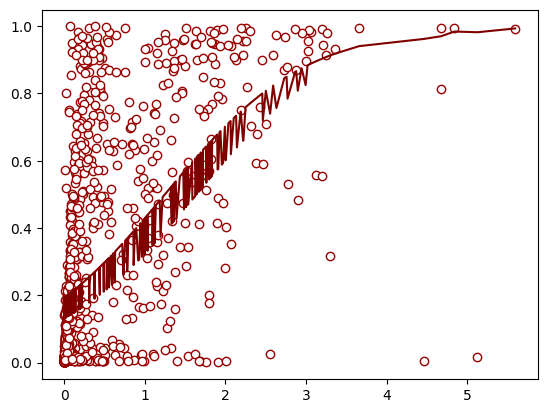

In [21]:
# plot prediction
predictions = model.predict(params=report.params)
pred_df = pd.DataFrame(
    np.array([data_df["firing_rate"], predictions]).T, columns=["firing_rate", "prediction"]
)
sorted_pred_df = pred_df.sort_values(by="firing_rate")

plt.plot(
    data_df["firing_rate"],
    data_df["sorting_accuracy"],
    "o",
    markerfacecolor="w",
    markeredgecolor=[0.6, 0, 0],
)

plt.plot(sorted_pred_df["firing_rate"], sorted_pred_df["prediction"], color=[0.5, 0, 0])

- prsquared: Cox-Snell Likelihood-Ratio pseudo-R-squared
- model.predict(params)
- report.get_prediction
- report.prsquared
- report.pseudo_rsquared
report.params

#### Measure features contributions (INCORRECT)

Fit on entire dataset

- the number of times the model iterates over the data, trying to optimize the model
- log-likelihood: the natural logarithm of the Maximum Likelihood Estimation(MLE) function. MLE is the optimization process of finding the set of parameters that result in the best fit.
- LL-null: the value of log-likelihood of the model when no independent variable is included(only an intercept is included).
- Pseudo R-squ: a substitute for the R-squared value in Least Squares linear regression. It is the ratio of the log-likelihood of the null model to that of the full model.

In [42]:
# building and train the model
log_reg = sm.Logit(y_train, x_train).fit()

# report
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.433511
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1310
Model:                          Logit   Df Residuals:                     1308
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                 0.08107
Time:                        02:22:03   Log-Likelihood:                -567.90
converged:                       True   LL-Null:                       -618.00
Covariance Type:            nonrobust   LLR p-value:                 1.373e-23
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
firing_rate       1.1290      0.107     10.554      0.000       0.919       1.339
synapse_class    -1.

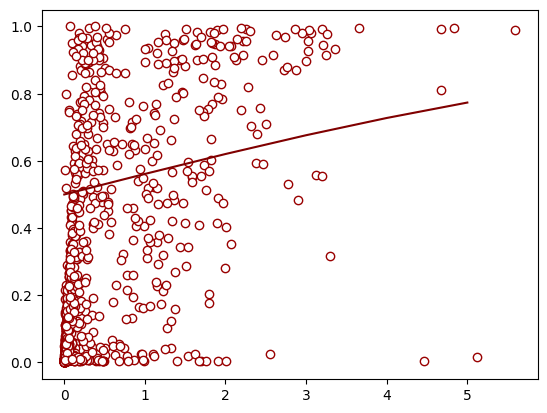

In [55]:
# predict
firing_rate_space = np.arange(0, max(firing_rates), 1)
preds = log_reg.predict(firing_rate_space)

# plot
plt.plot(firing_rates, y_train, "o", markerfacecolor="w", markeredgecolor=[0.6, 0, 0])
plt.plot(firing_rate_space, preds, color=[0.5, 0, 0])

In [56]:
SortingTrue.get_property_keys()

['model_type',
 'region',
 'morphology',
 'dynamics_input_resistance',
 'morph_class',
 'model_template',
 'orientation',
 'inh_mini_frequency',
 'orientation_w',
 'dynamics_holding_current',
 'exc_mini_frequency',
 'z',
 'me_combo',
 'sorting_accuracy',
 'firing_rates',
 'layer',
 'synapse_class',
 'orientation_z',
 'dynamics_threshold_current',
 'mtype',
 'orientation_y',
 'y',
 'x',
 'orientation_x',
 'etype',
 'dynamics_resting_potential']

### References

https://github.com/statsmodels/statsmodels/issues/9048